# Feature Matching: De Métodos Clásicos a Redes Neuronales

## Guía Práctica Experimental

---

Esta guía te lleva desde técnicas tradicionales hasta métodos modernos de feature matching. Cada sección incluye **zonas experimentales** donde podés cambiar parámetros y ver resultados inmediatos.

### Estructura del curso:

1. **Setup y fundamentos** - Configuración básica y conceptos clave
2. **SIFT tradicional** - Descriptores como vectores numéricos
3. **ORB eficiente** - Descriptores binarios y velocidad
4. **FLANN inteligente** - Búsqueda acelerada
5. **Métodos modernos** - Kornia y preparación para deep learning
6. **Aplicaciones prácticas** - Casos de uso reales

### Conceptos clave que vas a dominar:

- **Descriptores como embeddings** (base para redes neuronales)
- **Métricas de distancia** (fundamento de funciones de pérdida)
- **Trade-offs precisión vs velocidad**
- **Invarianzas aprendidas vs diseñadas**

**Importante**: Buscá las secciones **EXPERIMENTA** para cambiar parámetros y ver cómo afectan los resultados.

In [ ]:
!nvidia-smi

Wed Sep 17 23:44:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Setup del Entorno

In [ ]:
# Instalación básica - ejecutá esta celda primero
!pip install opencv-python matplotlib numpy -q

print("Librerías básicas instaladas")

Librerías básicas instaladas


In [ ]:
# Imports básicos y configuración
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 10

print("Setup básico completado")
print(f"OpenCV versión: {cv2.__version__}")

Setup básico completado
OpenCV versión: 4.12.0


In [ ]:
# Instalación de librerías avanzadas (opcional)
try:
    !pip install torch torchvision kornia -q
    import torch
    import kornia as K
    ADVANCED_LIBRARIES = True
    print(f"Librerías avanzadas disponibles:")
    print(f"- PyTorch: {torch.__version__}")
    print(f"- Kornia: {K.__version__}")
    print(f"- GPU disponible: {'Sí' if torch.cuda.is_available() else 'No'}")
except Exception as e:
    ADVANCED_LIBRARIES = False
    print(f"Librerías avanzadas no disponibles: {e}")
    print("Continuaremos con métodos tradicionales")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 111.5 MB/s eta 0:00:00
Librerías avanzadas disponibles:
- PyTorch: 2.8.0+cu126
- Kornia: 0.8.1
- GPU disponible: Sí


# 2. Carga de Imágenes Reales

In [ ]:
# Descarga de imágenes de Notre-Dame (mismas del cuaderno original)
print("Descargando imágenes de Notre-Dame de París...")

!wget -O imagen1.jpg "https://upload.wikimedia.org/wikipedia/commons/a/af/Notre-Dame_de_Paris_2013-07-24.jpg" -q
!wget -O imagen2.jpg "https://dynamic-media-cdn.tripadvisor.com/media/photo-o/0a/dc/ac/3e/photo0jpg.jpg?w=1400&h=800&s=1" -q

print("Descarga completada")

Descargando imágenes de Notre-Dame de París...
Descarga completada


In [ ]:
# Carga y preparación de imágenes
def cargar_y_redimensionar(ruta, max_ancho=800):
    """Carga imagen y la redimensiona si es necesario"""
    img = cv2.imread(ruta)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {ruta}")

    altura, ancho = img.shape[:2]
    if ancho > max_ancho:
        factor = max_ancho / ancho
        nuevo_ancho = max_ancho
        nueva_altura = int(altura * factor)
        img = cv2.resize(img, (nuevo_ancho, nueva_altura))
        print(f"Redimensionada de {ancho}x{altura} a {nuevo_ancho}x{nueva_altura}")

    return img

# Cargar imágenes
try:
    img1 = cargar_y_redimensionar('imagen1.jpg')
    img2 = cargar_y_redimensionar('imagen2.jpg')

    # Conversión a escala de grises
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    print(f"Imagen 1 cargada: {img1.shape}")
    print(f"Imagen 2 cargada: {img2.shape}")

except Exception as e:
    print(f"Error cargando imágenes: {e}")
    print("Verificá tu conexión a internet y volvé a ejecutar")

Redimensionada de 3348x4519 a 800x1079
Redimensionada de 1400x800 a 800x457
Imagen 1 cargada: (1079, 800, 3)
Imagen 2 cargada: (457, 800, 3)


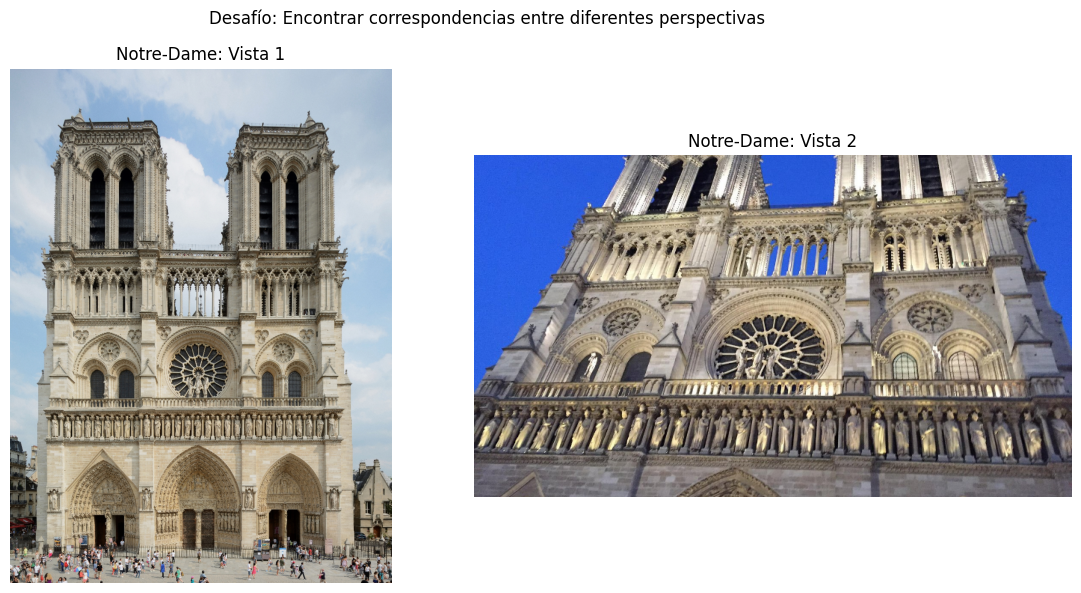

Estas imágenes tienen diferentes ángulos, iluminación y perspectiva
Nuestro objetivo: encontrar puntos que correspondan entre ambas


In [ ]:
# Visualización inicial
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Notre-Dame: Vista 1')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Notre-Dame: Vista 2')
ax2.axis('off')

plt.suptitle('Desafío: Encontrar correspondencias entre diferentes perspectivas')
plt.tight_layout()
plt.show()

print("Estas imágenes tienen diferentes ángulos, iluminación y perspectiva")
print("Nuestro objetivo: encontrar puntos que correspondan entre ambas")

# 3. SIFT: Descriptores como Vectores Numéricos

## Concepto fundamental para redes neuronales

Los descriptores SIFT son **vectores de 128 números** que describen características visuales. Este concepto es la base de los **embeddings** en deep learning.

In [ ]:
# ==================== ZONA EXPERIMENTAL ====================
# EXPERIMENTA cambiando estos parámetros:

# Número máximo de keypoints a detectar
nfeatures = 500          # Probá: 100, 500, 1000

# Sensibilidad del detector (más bajo = más sensible)
contrast_threshold = 0.04  # Probá: 0.01, 0.04, 0.08

# Filtro de bordes (más alto = menos keypoints en bordes)
edge_threshold = 10        # Probá: 5, 10, 20

# ============================================================

print("Configuración SIFT:")
print(f"- Keypoints máximos: {nfeatures}")
print(f"- Umbral de contraste: {contrast_threshold} (más bajo = más sensible)")
print(f"- Umbral de bordes: {edge_threshold} (más alto = menos bordes)")

# Crear detector SIFT
sift = cv2.SIFT_create(
    nfeatures=nfeatures,
    contrastThreshold=contrast_threshold,
    edgeThreshold=edge_threshold
)

print("\nDetector SIFT configurado")

Configuración SIFT:
- Keypoints máximos: 500
- Umbral de contraste: 0.04 (más bajo = más sensible)
- Umbral de bordes: 10 (más alto = menos bordes)

Detector SIFT configurado


In [ ]:
# Detección de keypoints y cálculo de descriptores
print("Detectando keypoints y calculando descriptores...")

# Detectar en ambas imágenes
start_time = time.time()
kp1, desc1 = sift.detectAndCompute(gray1, None)
kp2, desc2 = sift.detectAndCompute(gray2, None)
sift_time = time.time() - start_time

print(f"\nResultados SIFT:")
print(f"- Imagen 1: {len(kp1)} keypoints")
print(f"- Imagen 2: {len(kp2)} keypoints")
print(f"- Tiempo de procesamiento: {sift_time:.3f} segundos")
print(f"- Forma de descriptores: {desc1.shape}")
print(f"- Cada descriptor: vector de {desc1.shape[1]} números reales")

# Análisis de descriptores (concepto clave para embeddings)
print(f"\nAnálisis de descriptores (importante para redes neuronales):")
descriptor_ejemplo = desc1[0]
print(f"- Ejemplo descriptor: [{descriptor_ejemplo[:5].round(2)}...] (primeros 5 de 128)")
print(f"- Rango de valores: [{descriptor_ejemplo.min():.1f}, {descriptor_ejemplo.max():.1f}]")
print(f"- Norma L2: {np.linalg.norm(descriptor_ejemplo):.2f}")
print("\nEn redes neuronales, esto se llama 'embedding' o 'representación aprendida'")

Detectando keypoints y calculando descriptores...

Resultados SIFT:
- Imagen 1: 500 keypoints
- Imagen 2: 500 keypoints
- Tiempo de procesamiento: 0.461 segundos
- Forma de descriptores: (500, 128)
- Cada descriptor: vector de 128 números reales

Análisis de descriptores (importante para redes neuronales):
- Ejemplo descriptor: [[  0.   0.   0.   8. 150.]...] (primeros 5 de 128)
- Rango de valores: [0.0, 150.0]
- Norma L2: 512.92

En redes neuronales, esto se llama 'embedding' o 'representación aprendida'


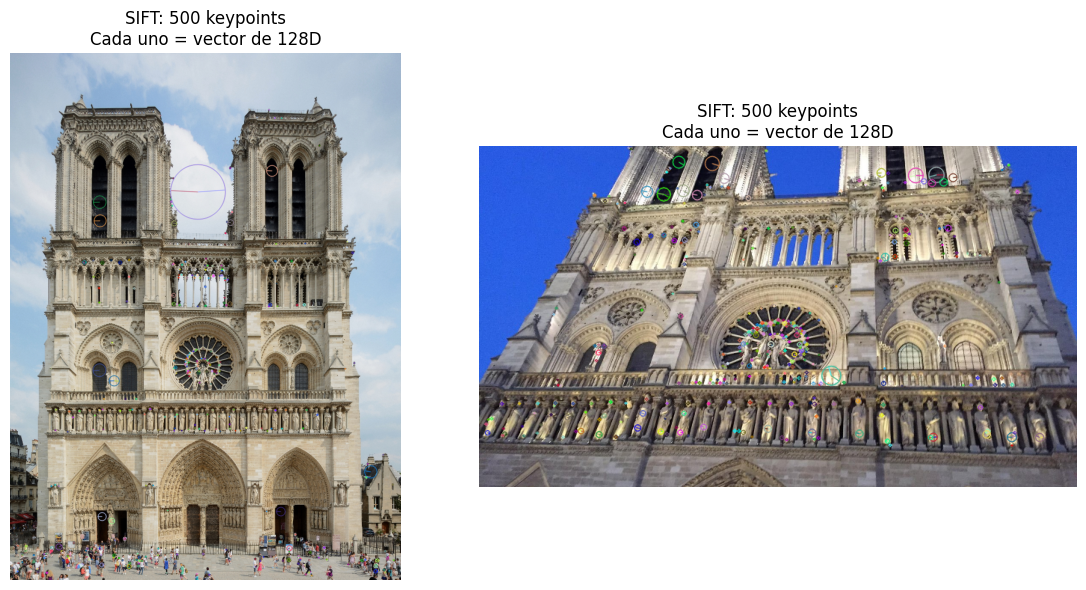

Interpretación:
- Cada círculo = keypoint detectado
- Tamaño del círculo = escala del keypoint
- Dirección = orientación principal
- Vector de 128 números describe el patrón visual alrededor del punto


In [ ]:
# Visualización de keypoints
img1_kp = cv2.drawKeypoints(img1, kp1, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, kp2, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
ax1.set_title(f'SIFT: {len(kp1)} keypoints\nCada uno = vector de 128D')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
ax2.set_title(f'SIFT: {len(kp2)} keypoints\nCada uno = vector de 128D')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("Interpretación:")
print("- Cada círculo = keypoint detectado")
print("- Tamaño del círculo = escala del keypoint")
print("- Dirección = orientación principal")
print("- Vector de 128 números describe el patrón visual alrededor del punto")

# 4. Feature Matching: Comparando Vectores

## Métricas de distancia (base de funciones de pérdida)

Para encontrar correspondencias, comparamos descriptores usando métricas de distancia. Este concepto es fundamental para las funciones de pérdida en redes neuronales.

In [ ]:
# ==================== ZONA EXPERIMENTAL ====================
# EXPERIMENTA con este parámetro clave:

# Umbral para el ratio test (más bajo = más estricto)
ratio_threshold = 0.7     # Probá: 0.5, 0.7, 0.8, 0.9

# ============================================================

print(f"Configuración de matching:")
print(f"- Ratio threshold: {ratio_threshold}")
print(f"- Métrica: Distancia euclidiana (L2)")
print(f"- Algoritmo: Búsqueda por fuerza bruta")

# Crear matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Buscar correspondencias (k=2 para ratio test)
matches = bf_matcher.knnMatch(desc1, desc2, k=2)

print(f"\nMatches candidatos encontrados: {len(matches)}")

Configuración de matching:
- Ratio threshold: 0.7
- Métrica: Distancia euclidiana (L2)
- Algoritmo: Búsqueda por fuerza bruta

Matches candidatos encontrados: 500


In [ ]:
# Aplicar ratio test (filtro de calidad)
good_matches = []
distances = []

for match_pair in matches:
    if len(match_pair) == 2:
        best_match, second_match = match_pair

        # Ratio test: el mejor debe ser significativamente mejor que el segundo
        if best_match.distance < ratio_threshold * second_match.distance:
            good_matches.append(best_match)
            distances.append(best_match.distance)

print(f"Resultados del filtrado:")
print(f"- Matches después del ratio test: {len(good_matches)}")
print(f"- Porcentaje aceptado: {len(good_matches)/len(matches)*100:.1f}%")
print(f"- Distancia promedio: {np.mean(distances):.2f}")
print(f"- Distancia mínima: {np.min(distances):.2f}")
print(f"- Distancia máxima: {np.max(distances):.2f}")

print(f"\nConcepto clave para redes neuronales:")
print(f"- Distancia L2 → base de MSE Loss")
print(f"- Ratio test → técnica de filtrado que las redes aprenden automáticamente")
print(f"- Threshold {ratio_threshold} → hiperparámetro ajustable")

Resultados del filtrado:
- Matches después del ratio test: 7
- Porcentaje aceptado: 1.4%
- Distancia promedio: 213.26
- Distancia mínima: 196.12
- Distancia máxima: 230.96

Concepto clave para redes neuronales:
- Distancia L2 → base de MSE Loss
- Ratio test → técnica de filtrado que las redes aprenden automáticamente
- Threshold 0.7 → hiperparámetro ajustable


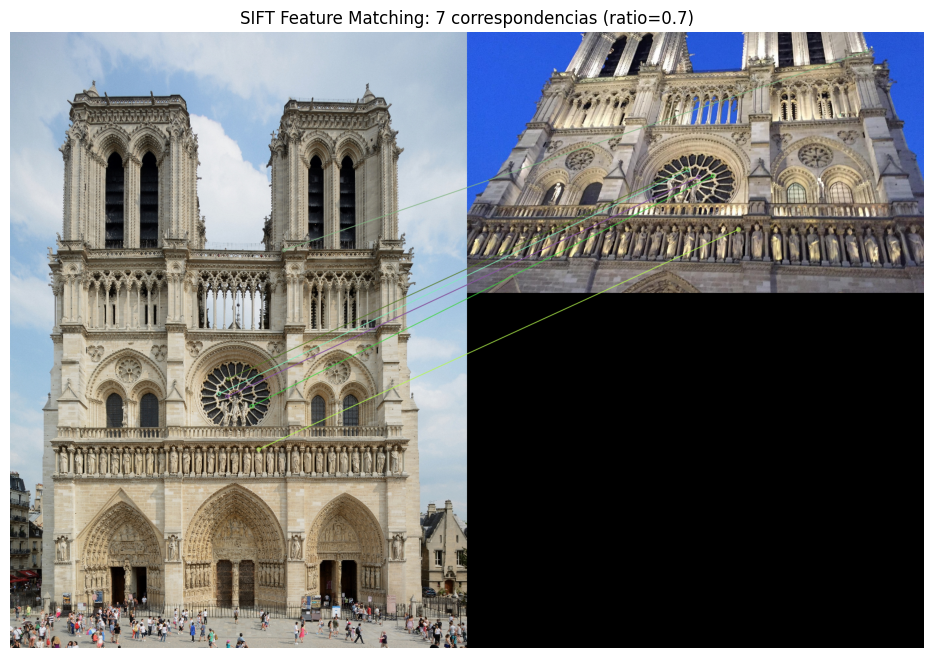

Interpretación:
- Cada línea conecta descriptores con distancia L2 similar
- Líneas correctas = puntos que realmente corresponden
- Líneas incorrectas = errores del algoritmo
- Con ratio 0.7: balance entre cantidad y calidad


In [ ]:
# Visualización de matches
if len(good_matches) > 0:
    matches_img = cv2.drawMatches(
        img1, kp1, img2, kp2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(matches_img, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Feature Matching: {len(good_matches)} correspondencias (ratio={ratio_threshold})')
    plt.axis('off')
    plt.show()

    print("Interpretación:")
    print("- Cada línea conecta descriptores con distancia L2 similar")
    print("- Líneas correctas = puntos que realmente corresponden")
    print("- Líneas incorrectas = errores del algoritmo")
    print(f"- Con ratio {ratio_threshold}: balance entre cantidad y calidad")
else:
    print("No se encontraron matches suficientes")
    print(f"Probá reducir ratio_threshold (actualmente {ratio_threshold})")

# 5. ORB: Descriptores Binarios vs Continuos

## Comparación de representaciones

ORB usa descriptores **binarios** (0s y 1s) en lugar de números reales. Esto es importante para entender quantización en redes neuronales.

In [ ]:
# ==================== ZONA EXPERIMENTAL ====================
# EXPERIMENTA con ORB:

# Configuración ORB
orb_nfeatures = 1000      # Probá: 500, 1000, 2000
orb_scale_factor = 1.2    # Probá: 1.1, 1.2, 1.5
orb_nlevels = 8           # Probá: 4, 8, 12

# Ratio test para ORB (típicamente más permisivo)
orb_ratio = 0.75          # Probá: 0.7, 0.75, 0.8

# ============================================================

print("Configuración ORB:")
print(f"- Features: {orb_nfeatures}")
print(f"- Scale factor: {orb_scale_factor} (robustez a cambios de tamaño)")
print(f"- Niveles: {orb_nlevels} (escalas de la pirámide)")
print(f"- Ratio threshold: {orb_ratio}")

# Crear detector ORB
orb = cv2.ORB_create(
    nfeatures=orb_nfeatures,
    scaleFactor=orb_scale_factor,
    nlevels=orb_nlevels
)

print("\nDetector ORB configurado")

Configuración ORB:
- Features: 1000
- Scale factor: 1.2 (robustez a cambios de tamaño)
- Niveles: 8 (escalas de la pirámide)
- Ratio threshold: 0.75

Detector ORB configurado


In [ ]:
# Comparación SIFT vs ORB
print("Comparando SIFT vs ORB...")

# ORB detection
start_time = time.time()
kp1_orb, desc1_orb = orb.detectAndCompute(gray1, None)
kp2_orb, desc2_orb = orb.detectAndCompute(gray2, None)
orb_time = time.time() - start_time

print(f"\nComparación de velocidad:")
print(f"- SIFT: {sift_time:.3f}s para {len(kp1)+len(kp2)} keypoints")
print(f"- ORB:  {orb_time:.3f}s para {len(kp1_orb)+len(kp2_orb)} keypoints")
print(f"- Aceleración: {sift_time/orb_time:.1f}x más rápido")

print(f"\nComparación de descriptores:")
print(f"- SIFT: {desc1.shape} números reales de 32 bits")
print(f"- ORB:  {desc1_orb.shape} enteros de 8 bits (representación binaria)")

# Análisis de descriptor binario
orb_ejemplo = desc1_orb[0]
print(f"\nDescriptor ORB ejemplo:")
print(f"- Valores: {orb_ejemplo[:10]} (primeros 10 de {len(orb_ejemplo)})")
print(f"- Rango: [{orb_ejemplo.min()}, {orb_ejemplo.max()}]")
print(f"- En binario cada número representa 8 bits")
print(f"- Total: {len(orb_ejemplo) * 8} bits por descriptor")

Comparando SIFT vs ORB...

Comparación de velocidad:
- SIFT: 0.461s para 1000 keypoints
- ORB:  0.306s para 2000 keypoints
- Aceleración: 1.5x más rápido

Comparación de descriptores:
- SIFT: (500, 128) números reales de 32 bits
- ORB:  (1000, 32) enteros de 8 bits (representación binaria)

Descriptor ORB ejemplo:
- Valores: [108 165 240 242 213 105 229 139 219 183] (primeros 10 de 32)
- Rango: [24, 242]
- En binario cada número representa 8 bits
- Total: 256 bits por descriptor


In [ ]:
# Matching con ORB (distancia de Hamming)
print("Feature matching con ORB...")

# Matcher para descriptores binarios
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches_orb = bf_orb.knnMatch(desc1_orb, desc2_orb, k=2)

# Ratio test
good_matches_orb = []
for match_pair in matches_orb:
    if len(match_pair) == 2:
        best, second = match_pair
        if best.distance < orb_ratio * second.distance:
            good_matches_orb.append(best)

print(f"\nResultados ORB:")
print(f"- Matches encontrados: {len(good_matches_orb)}")
print(f"- Métrica usada: Distancia de Hamming (cuenta bits diferentes)")
print(f"- Eficiencia: {len(good_matches_orb)/orb_time:.0f} matches/segundo")

print(f"\nComparación final:")
print(f"- SIFT: {len(good_matches)} matches, {len(good_matches)/sift_time:.0f} matches/s")
print(f"- ORB:  {len(good_matches_orb)} matches, {len(good_matches_orb)/orb_time:.0f} matches/s")

Feature matching con ORB...

Resultados ORB:
- Matches encontrados: 17
- Métrica usada: Distancia de Hamming (cuenta bits diferentes)
- Eficiencia: 56 matches/segundo

Comparación final:
- SIFT: 7 matches, 15 matches/s
- ORB:  17 matches, 56 matches/s


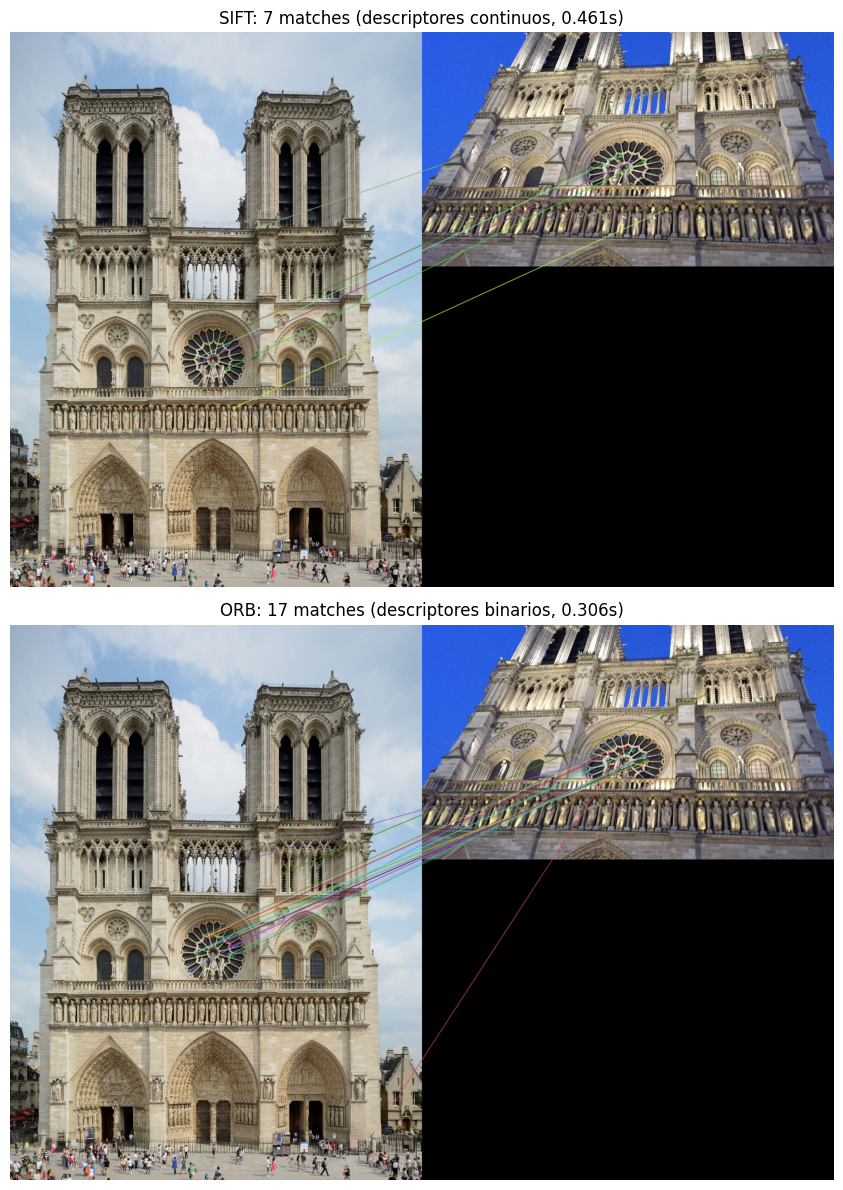

Conceptos clave para redes neuronales:
- Descriptores continuos vs binarios → embeddings vs quantización
- Trade-off velocidad vs precisión
- Distancia L2 vs Hamming → diferentes funciones de pérdida


In [ ]:
# Visualización comparativa
if len(good_matches_orb) > 0:
    matches_orb_img = cv2.drawMatches(
        img1, kp1_orb, img2, kp2_orb,
        good_matches_orb, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    if len(good_matches) > 0:
        ax1.imshow(cv2.cvtColor(matches_img, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'SIFT: {len(good_matches)} matches (descriptores continuos, {sift_time:.3f}s)')
    else:
        ax1.text(0.5, 0.5, 'SIFT: No hay matches para mostrar', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('SIFT: Sin matches')
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(matches_orb_img, cv2.COLOR_BGR2RGB))
    ax2.set_title(f'ORB: {len(good_matches_orb)} matches (descriptores binarios, {orb_time:.3f}s)')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    print("Conceptos clave para redes neuronales:")
    print("- Descriptores continuos vs binarios → embeddings vs quantización")
    print("- Trade-off velocidad vs precisión")
    print("- Distancia L2 vs Hamming → diferentes funciones de pérdida")
else:
    print("ORB no encontró matches suficientes")
    print("Probá ajustar orb_ratio o aumentar orb_nfeatures")

# Resumen y Guía de Experimentación

## Parámetros clave que podés modificar:

### SIFT (Sección 3):
- **nfeatures**: Número máximo de keypoints (100-1000)
- **contrast_threshold**: Sensibilidad (0.01-0.08, más bajo = más sensible)
- **edge_threshold**: Filtro de bordes (5-20, más alto = menos bordes)

### Feature Matching (Sección 4):
- **ratio_threshold**: Calidad del filtrado (0.5-0.9, más bajo = más estricto)

### ORB (Sección 5):
- **orb_nfeatures**: Cantidad de features (500-2000)
- **orb_scale_factor**: Robustez a escala (1.1-1.5)
- **orb_nlevels**: Niveles de pirámide (4-12)
- **orb_ratio**: Ratio test (0.7-0.8)

## Experimentos sugeridos:

1. **Comparar precisión vs velocidad**: Ajustá nfeatures en SIFT y ORB
2. **Probar robustez**: Cambiá ratio_threshold y observá quality vs quantity
3. **Explorar regiones**: Modificá region_x, region_y, region_w, region_h
4. **Optimizar FLANN**: Experimentá con trees y checks
5. **Comparar algoritmos**: Usa 'sift' vs 'orb' en el detector

## Para la próxima clase:

Los conceptos que dominaste (embeddings, métricas de distancia, invarianzas) son la base directa para entender:
- **CNNs**: Como extractores automáticos de features
- **Transformers**: Para matching con atención
- **Funciones de pérdida**: Optimización de embeddings
- **Transfer learning**: Adaptar features pre-entrenadas

**¡Seguí experimentando con los parámetros para internalizar estos conceptos!**

# EJEMPLOS CONCRETOS QUE USAS TODOS LOS DÍAS
========================================

*   **📷 Google Photos**
    *   Qué hace: Buscar 'perro' y encuentra todas las fotos con perros
    *   Cómo: Feature matching + CNN para clasificar objetos

*   **🔓 Face ID (iPhone)**
    *   Qué hace: Te reconoce incluso con barba nueva o anteojos
    *   Cómo: Keypoints faciales + matching robusto a cambios

*   **🌍 Google Street View**
    *   Qué hace: Panoramas 360° perfectos sin costuras
    *   Cómo: Feature matching para unir fotos superpuestas

*   **🎮 Pokémon GO**
    *   Qué hace: Pokémons aparecen 'sobre' objetos reales
    *   Cómo: SLAM + feature tracking para AR

*   **🚗 Tesla Autopilot**
    *   Qué hace: Reconoce carriles, autos, peatones en tiempo real
    *   Cómo: Multi-camera feature matching + CNNs

*   **📱 Snapchat/Instagram**
    *   Qué hace: Filtros que siguen tu cara perfectamente**
    *   Cómo: Facial landmarks + tracking en tiempo real

*   **🛒 Amazon**
    *   Qué hace: Buscar productos sacándoles una foto
    *   Cómo: Visual search con feature embeddings

*   **🏥 Rayos X automáticos**
    *   Qué hace: Detecta fracturas automáticamente
    *   Cómo: Medical image registration + deep learning

==================================================
🎓 LO QUE APRENDISTE HOY ES LA BASE DE TODO ESTO

*   **SIFT/ORB** → Feature extraction (paso 1 de cualquier sistema)
*   **Descriptores** → Embeddings (corazón de deep learning)
*   **Matching** → Similarity search (recomendaciones, búsquedas)
*   **FLANN** → Escalabilidad (para millones de imágenes)
*   **Kornia** → Puente hacia métodos modernos con gradientes

# INDUSTRIAS QUE USAN FEATURE MATCHING HOY:
==================================================

### 🏥 MEDICINA
*   Registro de imágenes médicas (MRI, CT scan alignment)
*   Cirugía guiada por imagen en tiempo real
*   Detección automática de tumores entre estudios
*   Seguimiento de implantes y prótesis

### 🚗 AUTOMOTRIZ
*   Sistemas ADAS: detección de obstáculos y peatones
*   Estacionamiento automático (reconoce espacios)
*   Navegación visual para vehículos autónomos
*   Control de calidad en líneas de producción

### 📱 IT
*   Face ID y desbloqueo facial de smartphones
*   Google Lens: buscar productos con la cámara
*   Realidad aumentada (Snapchat, Instagram filters)
*   Traducción instantánea de texto en imágenes

### 🏭 MANUFACTURA
*   Inspección automática de soldaduras y defectos
*   Guía de robots para ensamblaje de precisión
*   Control de calidad en productos farmacéuticos
*   Clasificación automática de componentes

### 🌍 GEOESPACIAL
*   Google Earth: unir fotos satelitales
*   Mapeo con drones para agricultura de precisión
*   Monitoreo de deforestación y cambio climático
*   Navegación GPS visual en interiores

### 🎮 ENTRETENIMIENTO
*   Motion capture para animación y videojuegos
*   Efectos especiales en cine (match moving)
*   Realidad virtual: tracking de movimiento
*   Filtros de redes sociales en tiempo real

### 🏛️ PATRIMONIO
*   Reconstrucción 3D de monumentos históricos
*   Monitoreo de deterioro en obras de arte
*   Turismo virtual en museos
*   Documentación de sitios arqueológicos

### 🔒 SEGURIDAD
*   Sistemas de videovigilancia inteligente
*   Reconocimiento de matrículas automático
*   Análisis forense de imágenes
*   Control de acceso biométrico
